In [1]:
# Import necessary libraries
import pandas as pd  # Used for data manipulation and analysis
import numpy as np  # Used for numerical operations and array handling
import matplotlib.pyplot as plt  # Used for data visualization

# Import scikit-learn utilities for preprocessing and model evaluation
from sklearn.preprocessing import LabelEncoder  # Encodes target labels with value between 0 and n_classes-1
from sklearn.model_selection import train_test_split, StratifiedKFold  # Splits data into training and testing sets, and provides cross-validation with stratified folds
from sklearn.utils.class_weight import compute_class_weight  # Computes class weights to handle class imbalance

# Import necessary Keras modules for deep learning model building and training
from tensorflow.keras.models import Sequential  # Used to initialize a sequential model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Common layers used in Convolutional Neural Networks (CNN)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Generates batches of tensor image data with real-time data augmentation
from tensorflow.keras.utils import to_categorical  # Converts a class vector (integers) to binary class matrix for use with categorical cross-entropy loss
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training the model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks to stop training early and reduce learning rate on plateau

# Import pydicom for handling DICOM images, commonly used in medical imaging
import pydicom  # Used to read and process DICOM files, the standard format for medical imaging data
import os  # Provides a way of using operating system dependent functionality such as reading files from the directory
import concurrent.futures  # Provides a high-level interface for asynchronously executing callables

# Import l2 regularizer to prevent overfitting by adding a penalty to the loss function based on the weights
from tensorflow.keras.regularizers import l2  # Adds L2 regularization to layers to reduce model overfitting risk


In [2]:
# Load and inspect the CSV files
train_labels_df = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train_labels.csv')
test_labels_df = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//test_labels.csv')

In [3]:
# Check for unique labels and their distribution in the training and testing datasets
print("Train Labels DataFrame:")
# Display the count of each unique label in the training dataset
# This helps to understand the class distribution and identify any imbalance in the data
print(train_labels_df['label'].value_counts())

print("\nTest Labels DataFrame:")
# Display the count of each unique label in the testing dataset
# Understanding the test set distribution is crucial for evaluating model performance on unseen data
print(test_labels_df['label'].value_counts())


Train Labels DataFrame:
label
1550325930    192
47603740      176
1931643682    176
56020246      176
2853044871    176
             ... 
2972736368      8
1341167394      7
2518174510      7
2689348626      6
983684394       5
Name: count, Length: 6294, dtype: int64

Test Labels DataFrame:
label
3481971518    47
2828203845    25
3844393089    25
Name: count, dtype: int64


In [4]:
# Load the other data files
train = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train.csv')
train_label_coordinates = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train_label_coordinates.csv')
train_series_descriptions = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train_series_descriptions.csv')
test_series_descriptions = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//test_series_descriptions.csv')
sample_submission = pd.read_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//sample_submission.csv')

In [5]:
# Handle missing data in the training DataFrame
for column in train.columns:
    # To Check if there are missing values in the column
    if train[column].isnull().sum() > 0:
        # If the column is categorical (dtype 'object'), fill missing values with the mode (most frequent value)
        if train[column].dtype == 'object':  
            train[column].fillna(train[column].mode()[0], inplace=True)
        else:  # If the column is numerical, fill missing values with the mean of the column
            train[column].fillna(train[column].mean(), inplace=True)

# Convert columns with categorical data to 'category' dtype to optimize memory usage and facilitate encoding
categorical_columns = train.select_dtypes(include=['object']).columns
train[categorical_columns] = train[categorical_columns].astype('category')

# Define a mapping for severity levels to convert ordinal data into numerical form
severity_mapping = {
    'Mild': 1,        # Mild severity is mapped to 1
    'Moderate': 2,    # Moderate severity is mapped to 2
    'Severe': 3       # Severe severity is mapped to 3
}

# Apply severity mapping to any columns containing the ordinal severity levels
for col in train.columns:
    # Check if the column values match the severity labels, ensuring it's an ordinal column
    if set(train[col].dropna().unique()) <= {'Mild', 'Moderate', 'Severe'}:
        train[col] = train[col].map(severity_mapping)  # Apply the mapping to convert to numerical values

# Display the first few rows of the modified DataFrame to check changes
train.head()


C:\Users\srira\AppData\Local\Temp\ipykernel_16844\3195464869.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[column].fillna(train[column].mode()[0], inplace=True)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [6]:
# Drop duplicate rows from each DataFrame to ensure data quality
train.drop_duplicates(inplace=True)  # Removes duplicate entries from the training data
train_label_coordinates.drop_duplicates(inplace=True)  # Removes duplicates from the label coordinates data
train_series_descriptions.drop_duplicates(inplace=True)  # Removes duplicates from the series descriptions of the training set
test_series_descriptions.drop_duplicates(inplace=True)  # Removes duplicates from the series descriptions of the test set

# Save the cleaned DataFrames to CSV files for further analysis or training
# Saving the cleaned data helps preserve the preprocessing steps and allows easy access for model training and evaluation
train.to_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//cleaned_train.csv', index=False)
train_label_coordinates.to_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//cleaned_train_label_coordinates.csv', index=False)
train_series_descriptions.to_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//cleaned_train_series_descriptions.csv', index=False)
test_series_descriptions.to_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//cleaned_test_series_descriptions.csv', index=False)
sample_submission.to_csv('D://rsna//rsna-2024-lumbar-spine-degenerative-classification//cleaned_sample_submission.csv', index=False)


In [7]:
# Define the relevant columns related to spinal data
# Selecting columns that contain terms like 'stenosis' or 'narrowing' 
# which are critical for diagnosing degenerative spinal conditions
spinal_columns = [col for col in train.columns if 'stenosis' in col or 'narrowing' in col]

# Prepare features (X) and labels (y)
# Features (X) include all columns except 'study_id' which is an identifier not needed for modeling
X = train.drop(columns=['study_id'])
# Labels (y) are specific spinal condition columns identified above, which will be used as target variables
y = train[spinal_columns]

# Encode labels using LabelEncoder to convert categorical labels into numerical form
label_encoders = {}  # Dictionary to store label encoders for each column, useful for decoding later
for column in y.columns:
    le = LabelEncoder()  # Initialize a label encoder for each column
    y[column] = le.fit_transform(y[column])  # Transform the categorical values into numeric form
    label_encoders[column] = le  # Store the label encoder for potential inverse transformations


C:\Users\srira\AppData\Local\Temp\ipykernel_16844\1996774937.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column] = le.fit_transform(y[column])
C:\Users\srira\AppData\Local\Temp\ipykernel_16844\1996774937.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[column] = le.fit_transform(y[column])
C:\Users\srira\AppData\Local\Temp\ipykernel_16844\1996774937.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [8]:
# Function to load and resize a DICOM image
def read_dicom(file_path, target_size):
    # Read the DICOM file using pydicom
    dicom = pydicom.dcmread(file_path)
    # Extract the pixel array (image data) from the DICOM file
    image = dicom.pixel_array
    # Resize the image to the specified target size (e.g., 300x300)
    image = np.resize(image, target_size)
    return image

# Function to load DICOM images in parallel with optional label handling
def load_dicom_images_parallel(directory, labels_file=None, target_size=(300, 300), limit=None):
    images = []  # List to store the loaded images
    labels = []  # List to store the corresponding labels
    label_map = {}  # Dictionary to map file names to labels

    # Load labels if a label file is provided
    if labels_file:
        labels_df = pd.read_csv(labels_file)  # Read the labels file as a DataFrame
        
        # Create a mapping of file names to their corresponding labels
        for idx, row in labels_df.iterrows():
            label_map[row['file_name']] = row['label']

    file_paths = []  # List to store paths of DICOM files
    # Walk through the directory to find all DICOM files
    for root, _, files in os.walk(directory):
        for file_name in files:
            if file_name.endswith('.dcm'):  # Check if the file is a DICOM file
                file_path = os.path.join(root, file_name)
                file_paths.append(file_path)

    # Limit the number of files to load, if specified
    if limit:
        file_paths = file_paths[:limit]

    # Load images in parallel using ThreadPoolExecutor for faster processing
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Submit tasks to the executor, creating a future for each file to be processed
        futures = {executor.submit(read_dicom, file_path, target_size): file_path for file_path in file_paths}
        for future in concurrent.futures.as_completed(futures):
            file_path = futures[future]
            try:
                # Retrieve the processed image from the future
                image = future.result()
                images.append(image)  # Add the image to the list of images
                file_name = os.path.basename(file_path)  # Extract the file name from the path
                
                # Retrieve the label from the label_map if available
                if file_name in label_map:
                    label = label_map[file_name]
                else:
                    label = -1  # Use -1 as a fallback value for missing labels
                    print(f"Warning: No label found for {file_name}. Assigning default label {label}.")
                
                labels.append(label)  # Add the label to the list of labels
            except Exception as exc:
                # Handle exceptions that occur during image processing
                print(f'{file_path} generated an exception: {exc}')
    
    # Return the loaded images and labels as NumPy arrays
    return np.array(images), np.array(labels)
    print(np.array(images), np.array(labels))  # Print statement to visualize arrays (Note: this line is after the return, so it won't execute)


In [9]:
# Load training images and their corresponding labels
train_images, train_image_labels = load_dicom_images_parallel(
    'D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train_images',  # Directory containing training DICOM images
    labels_file='D://rsna//rsna-2024-lumbar-spine-degenerative-classification//train_labels.csv',  # CSV file containing labels for the training images
    limit=10000  # Limit the number of images to load (e.g., for memory or speed considerations)
)

# Load test images and their corresponding labels
test_images, test_image_labels = load_dicom_images_parallel(
    'D://rsna//rsna-2024-lumbar-spine-degenerative-classification//test_images',  # Directory containing test DICOM images
    labels_file='D://rsna//rsna-2024-lumbar-spine-degenerative-classification//test_labels.csv',  # CSV file containing labels for the test images
    limit=1000  # Limit the number of images to load
)


In [10]:
# Verify that the loaded training data is not empty
if train_images.size == 0 or train_image_labels.size == 0:
    print("Error: No training images or labels found.")  # Print error if training images or labels are empty

# Verify that the loaded test data is not empty
if test_images.size == 0 or test_image_labels.size == 0:
    print("Error: No test images or labels found.")  # Print error if test images or labels are empty

# Additional check: Raise an exception if training labels are empty to stop further processing
if len(train_image_labels) == 0:
    raise ValueError("train_image_labels array is empty.")  # Raise an error to ensure no empty labels go unnoticed

# Additional check: Raise an exception if test labels are empty to stop further processing
if len(test_image_labels) == 0:
    raise ValueError("test_image_labels array is empty.")  # Raise an error to prevent training with missing test labels



In [11]:
# Cap labels to a reasonable value to handle any outliers or erroneous values
# Setting a maximum value for the labels helps in controlling the range of target values, ensuring consistent class boundaries
max_reasonable_value = 10  # Define the maximum reasonable label value based on the dataset specifics

# Apply capping to the training labels using np.clip, which limits values between 0 and max_reasonable_value
train_image_labels = np.clip(train_image_labels, 0, max_reasonable_value)

# Apply capping to the test labels similarly
test_image_labels = np.clip(test_image_labels, 0, max_reasonable_value)

# Determine the number of classes for the classification task
# This calculates the maximum label value from both training and test labels, then adds 1 (for zero-indexing)
num_classes = max(train_image_labels.max(), test_image_labels.max()) + 1


In [12]:
# Add a channel dimension to the images
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Normalize images
train_images = train_images / 255.0
test_images = test_images / 255.0

# Convert labels to categorical
train_image_labels = to_categorical(train_image_labels, num_classes=num_classes)
test_image_labels = to_categorical(test_image_labels, num_classes=num_classes)

In [13]:
# Define the input shape based on your image data dimensions
# Here, the images are assumed to be grayscale (hence '1' in the third dimension) with 300x300 pixels
input_shape = (300, 300, 1)  # Adjust based on actual image size and number of channels

# Define the number of classes based on capped label values plus one for zero indexing
num_classes = 11  # Update this value based on the actual number of distinct classes

# Define the Convolutional Neural Network model
model = Sequential()

# First convolutional layer with increased l2 regularization to reduce overfitting
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer to reduce spatial dimensions
model.add(BatchNormalization())  # Normalization to improve training stability
model.add(Dropout(0.7))  # Increased dropout rate for regularization

# Second convolutional layer with increased l2 regularization
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))  # Pooling layer to further reduce spatial dimensions
model.add(BatchNormalization())  # Normalization layer
model.add(Dropout(0.7))  # Dropout to further prevent overfitting

# Flattening the output to feed into the fully connected layers
model.add(Flatten())

# Dense layer with increased l2 regularization and ReLU activation
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))  # High dropout rate to promote robust feature learning

# Output layer with softmax activation for multi-class classification
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])



C:\Users\srira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Data augmentation configuration to artificially increase the diversity of the training dataset
datagen = ImageDataGenerator(
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,             # Apply shear transformation with a shear intensity of up to 20%
    zoom_range=0.2,              # Randomly zoom into images by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally
    fill_mode='nearest'          # Filling strategy for new pixels generated during transformations
)

# Early stopping callback to prevent overfitting by stopping training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss to determine when to stop
    patience=3,                  # Number of epochs with no improvement before stopping
    restore_best_weights=True    # Restore model weights from the epoch with the best validation loss
)

# Reduce learning rate on plateau callback to dynamically adjust learning rate during training
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',          # Monitor validation loss to trigger learning rate reduction
    factor=0.2,                  # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,                  # Number of epochs with no improvement before reducing the learning rate
    min_lr=0.0001                # Minimum learning rate to avoid excessively small learning rates
)


In [15]:
# Split the data into training and validation sets
# Using stratified split to ensure each class is proportionally represented in both training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_images,               # Input images from the training set
    train_image_labels,         # Corresponding labels for the input images
    test_size=0.3,              # 30% of the data will be used for validation
    random_state=42,            # Seed for reproducibility
    stratify=train_image_labels # Ensures the split maintains the distribution of labels
)

# Train the model using augmented data from the ImageDataGenerator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Augmented training data with batch size of 32
    epochs=3,                                      # Number of training epochs
    validation_data=(X_val, y_val),                # Validation data to monitor performance during training
    callbacks=[early_stopping, reduce_lr]          # Use early stopping and learning rate reduction callbacks
)

# Evaluate the model on the test set to assess generalization performance
test_loss, test_accuracy = model.evaluate(test_images, test_image_labels)
print(f'Test accuracy: {test_accuracy}')  # Print the accuracy on the test data

# Save the trained model to an HDF5 file for future use
model.save('spine_degenerative_cnn_model.h5')

# Print a summary of the model architecture, including layers, shapes, and parameter counts
print(model.summary())


Epoch 1/3


C:\Users\srira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


219/219 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9159 - loss: 22.1183 - val_accuracy: 1.0000 - val_loss: 17.2653 - learning_rate: 0.0010
Epoch 2/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9926 - loss: 16.5121 - val_accuracy: 1.0000 - val_loss: 13.2778 - learning_rate: 0.0010
Epoch 3/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step - accuracy: 0.9916 - loss: 15.6774 - val_accuracy: 1.0000 - val_loss: 16.8545 - learning_rate: 0.0010
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 13.2778


Test accuracy: 1.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 149, 149, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 73, 73, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 341056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      43,655,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 11)                  │           1,419 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,027,363 (499.83 MB)

 Trainable params: 43,675,723 (166.61 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 87,351,448 (333.22 MB)

None


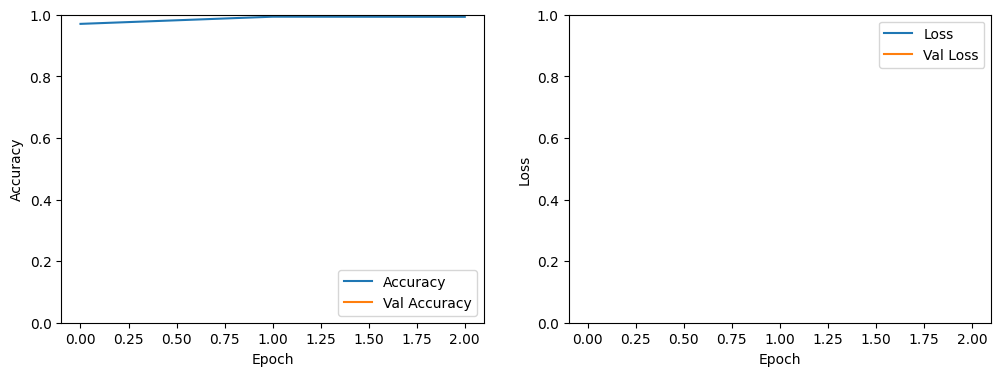

In [16]:
# Function to plot training and validation performance metrics
def plot_performance(history):
    # Set up the figure size for the plots
    plt.figure(figsize=(12, 4))
    
    # Plot training and validation accuracy over epochs
    plt.subplot(1, 2, 1)  # Create a subplot for accuracy
    plt.plot(history.history['accuracy'], label='Accuracy')  # Plot training accuracy
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')  # Plot validation accuracy
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Accuracy')  # Label for the y-axis
    plt.ylim([0, 1])  # Set y-axis limits from 0 to 1 (percentage scale)
    plt.legend(loc='lower right')  # Place the legend in the lower right corner
    
    # Plot training and validation loss over epochs
    plt.subplot(1, 2, 2)  # Create a subplot for loss
    plt.plot(history.history['loss'], label='Loss')  # Plot training loss
    plt.plot(history.history['val_loss'], label='Val Loss')  # Plot validation loss
    plt.xlabel('Epoch')  # Label for the x-axis
    plt.ylabel('Loss')  # Label for the y-axis
    plt.ylim([0, 1])  # Set y-axis limits from 0 to 1
    plt.legend(loc='upper right')  # Place the legend in the upper right corner
    
    # Display the plots
    plt.show()

# Call the function to plot the performance of the model
plot_performance(history)
